In [324]:
# %pip install onnx

In [325]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from pathlib import Path

from time import time
from tqdm import tqdm

# Download dataset

In [326]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [327]:
global_path = Path('/content/drive/MyDrive/Mag_course/CV_lab2')
save_path = global_path / "weights"

In [328]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [329]:
trainset = datasets.MNIST(global_path, download=True, train=True, transform=transform)
testset = datasets.MNIST(global_path, download=True, train=False, transform=transform)

In [330]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Train loop

In [331]:
def train_model(model_, trainloader_, testloader_, criterion_, optimizer_, epochs):

  time0 = time()
  for ep in tqdm(range(epochs)):
      if ep == 0:
          print()
      running_loss = 0
      for i, (images, labels) in enumerate(trainloader_, 0):
          optimizer_.zero_grad()
          res = model_(images)
          loss = criterion_(res, labels)
          loss.backward()
          optimizer_.step()

          running_loss += loss.item()

          dbg_samples = 100
          if (i + 1) % dbg_samples == 0:
              print('[%d, %5d] loss: %.3f' %
                    (e+1, i+1, running_loss / dbg_samples))
              running_loss = 0.0

  print("\nTraining Time (in minutes) =",(time()-time0)/60)

  correct = 0
  total = 0
  all_labels, all_predicted = [], []
  with torch.no_grad():
      for data in testloader_:
          images, labels = data
          outputs = model_(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          all_labels.extend(labels.cpu().numpy())
          all_predicted.extend(predicted.cpu().numpy())

  accuracy = 100 * correct / total

  return all_labels, all_predicted, accuracy

# Base model

In [332]:
class Net_Base(nn.Module):
    def __init__(self):
        super(Net_Base, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.fc1 = nn.Linear(8 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x2 = F.relu(self.conv2(x))
        x = x + x2
        x = self.pool(x)
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [333]:
net = Net_Base()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

In [334]:
all_labels, all_predicted, accuracy = train_model(net, trainloader, testloader, criterion, optimizer, epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]


[1,   100] loss: 2.273
[1,   200] loss: 1.916
[1,   300] loss: 0.720
[1,   400] loss: 0.387
[1,   500] loss: 0.299
[1,   600] loss: 0.242
[1,   700] loss: 0.199
[1,   800] loss: 0.190
[1,   900] loss: 0.181


100%|██████████| 1/1 [00:23<00:00, 23.30s/it]



Training Time (in minutes) = 0.38851598898569745


In [335]:
print('Accuracy: %d %%' % (accuracy))

print("\nClassification Report:")
print(classification_report(all_labels, all_predicted, digits=4))

Accuracy: 95 %

Classification Report:
              precision    recall  f1-score   support

           0     0.9782    0.9602    0.9691       980
           1     0.9791    0.9885    0.9838      1135
           2     0.9492    0.9409    0.9450      1032
           3     0.9547    0.9594    0.9570      1010
           4     0.9643    0.9633    0.9638       982
           5     0.9423    0.9709    0.9564       892
           6     0.9533    0.9582    0.9558       958
           7     0.9726    0.9309    0.9513      1028
           8     0.9318    0.9394    0.9356       974
           9     0.9307    0.9455    0.9381      1009

    accuracy                         0.9559     10000
   macro avg     0.9556    0.9557    0.9556     10000
weighted avg     0.9561    0.9559    0.9559     10000



In [336]:
x = torch.randn(64, 1, 28,28)
torch.onnx.export(net, x, save_path / "conv_1.onnx")

# Depthwise convolutions

In [337]:
class Net_Deptwise(nn.Module):
    def __init__(self):
        super(Net_Deptwise, self).__init__()
        self.depthwise1 = nn.Conv2d(1, 1, kernel_size=5, padding=2, groups=1)
        self.pointwise1 = nn.Conv2d(1, 8, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.depthwise2 = nn.Conv2d(8, 8, kernel_size=3, padding=1, groups=8)
        self.pointwise2 = nn.Conv2d(8, 8, kernel_size=1)

        self.fc1 = nn.Linear(8 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):
        x = self.depthwise1(x)
        x = self.pointwise1(x)
        x = F.relu(x)
        x = self.pool(x)

        x2 = self.depthwise2(x)
        x2 = self.pointwise2(x2)
        x2 = F.relu(x2)
        x = x + x2

        x = self.pool(x)
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [338]:
net = Net_Deptwise()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

In [339]:
all_labels, all_predicted, accuracy = train_model(net, trainloader, testloader, criterion, optimizer, epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]


[1,   100] loss: 2.291
[1,   200] loss: 2.131
[1,   300] loss: 1.173
[1,   400] loss: 0.591
[1,   500] loss: 0.453
[1,   600] loss: 0.354
[1,   700] loss: 0.323
[1,   800] loss: 0.290
[1,   900] loss: 0.259


100%|██████████| 1/1 [00:25<00:00, 25.79s/it]



Training Time (in minutes) = 0.4298717419306437


In [340]:
print('Accuracy: %d %%' % (accuracy))

print("\nClassification Report:")
print(classification_report(all_labels, all_predicted, digits=4))

Accuracy: 91 %

Classification Report:
              precision    recall  f1-score   support

           0     0.9299    0.9745    0.9517       980
           1     0.9576    0.9753    0.9664      1135
           2     0.9394    0.9157    0.9274      1032
           3     0.9250    0.9406    0.9327      1010
           4     0.9622    0.8289    0.8906       982
           5     0.9620    0.9070    0.9336       892
           6     0.9802    0.8800    0.9274       958
           7     0.8257    0.9630    0.8891      1028
           8     0.8757    0.9045    0.8899       974
           9     0.8188    0.8375    0.8280      1009

    accuracy                         0.9139     10000
   macro avg     0.9176    0.9127    0.9137     10000
weighted avg     0.9172    0.9139    0.9141     10000



In [341]:
x = torch.randn(64, 1, 28,28)
torch.onnx.export(net, x, save_path / "conv_2.onnx")

# Augmentations

In [342]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: 1 - x),
    transforms.Normalize((0.1307,), (0.3081,)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: 1 - x),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [343]:
trainset_aug = datasets.MNIST(global_path, download=True, train=True, transform=train_transform)
testset_aug = datasets.MNIST(global_path, download=True, train=False, transform=test_transform)

trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=64, shuffle=True)
testloader_aug = torch.utils.data.DataLoader(testset_aug, batch_size=64, shuffle=False)

In [352]:
net = Net_Deptwise()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

In [353]:
all_labels, all_predicted, accuracy = train_model(net, trainloader_aug, testloader_aug, criterion, optimizer, epochs=7)

  0%|          | 0/10 [00:00<?, ?it/s]


[1,   100] loss: 2.295
[1,   200] loss: 2.133
[1,   300] loss: 1.545
[1,   400] loss: 1.225
[1,   500] loss: 1.016
[1,   600] loss: 0.840
[1,   700] loss: 0.767
[1,   800] loss: 0.647
[1,   900] loss: 0.604


 10%|█         | 1/10 [01:03<09:35, 63.92s/it]

[1,   100] loss: 0.552
[1,   200] loss: 0.529
[1,   300] loss: 0.481
[1,   400] loss: 0.455
[1,   500] loss: 0.464
[1,   600] loss: 0.445
[1,   700] loss: 0.442
[1,   800] loss: 0.413
[1,   900] loss: 0.419


 20%|██        | 2/10 [01:53<07:22, 55.30s/it]

[1,   100] loss: 0.376
[1,   200] loss: 0.375
[1,   300] loss: 0.373
[1,   400] loss: 0.367
[1,   500] loss: 0.353
[1,   600] loss: 0.351
[1,   700] loss: 0.318
[1,   800] loss: 0.324
[1,   900] loss: 0.325


 30%|███       | 3/10 [02:41<06:05, 52.22s/it]

[1,   100] loss: 0.299
[1,   200] loss: 0.309
[1,   300] loss: 0.309
[1,   400] loss: 0.301
[1,   500] loss: 0.298
[1,   600] loss: 0.296
[1,   700] loss: 0.295
[1,   800] loss: 0.287
[1,   900] loss: 0.301


 40%|████      | 4/10 [03:51<05:54, 59.08s/it]

[1,   100] loss: 0.284
[1,   200] loss: 0.280
[1,   300] loss: 0.271
[1,   400] loss: 0.274
[1,   500] loss: 0.253
[1,   600] loss: 0.267
[1,   700] loss: 0.269
[1,   800] loss: 0.256
[1,   900] loss: 0.249


 50%|█████     | 5/10 [05:04<05:20, 64.15s/it]

[1,   100] loss: 0.273
[1,   200] loss: 0.252
[1,   300] loss: 0.251
[1,   400] loss: 0.243
[1,   500] loss: 0.265
[1,   600] loss: 0.240
[1,   700] loss: 0.225
[1,   800] loss: 0.239
[1,   900] loss: 0.237


 60%|██████    | 6/10 [06:07<04:15, 63.79s/it]

[1,   100] loss: 0.233
[1,   200] loss: 0.228
[1,   300] loss: 0.229
[1,   400] loss: 0.238
[1,   500] loss: 0.209
[1,   600] loss: 0.220
[1,   700] loss: 0.224
[1,   800] loss: 0.219
[1,   900] loss: 0.220


 70%|███████   | 7/10 [07:20<03:19, 66.65s/it]

[1,   100] loss: 0.208
[1,   200] loss: 0.200
[1,   300] loss: 0.207
[1,   400] loss: 0.213
[1,   500] loss: 0.200
[1,   600] loss: 0.218
[1,   700] loss: 0.239
[1,   800] loss: 0.208
[1,   900] loss: 0.211


 80%|████████  | 8/10 [08:14<02:05, 62.65s/it]

[1,   100] loss: 0.209
[1,   200] loss: 0.216
[1,   300] loss: 0.203
[1,   400] loss: 0.188
[1,   500] loss: 0.217
[1,   600] loss: 0.202
[1,   700] loss: 0.203
[1,   800] loss: 0.210
[1,   900] loss: 0.200


 90%|█████████ | 9/10 [09:03<00:58, 58.38s/it]

[1,   100] loss: 0.205
[1,   200] loss: 0.195
[1,   300] loss: 0.193
[1,   400] loss: 0.216
[1,   500] loss: 0.199
[1,   600] loss: 0.206
[1,   700] loss: 0.187
[1,   800] loss: 0.193
[1,   900] loss: 0.195


100%|██████████| 10/10 [10:07<00:00, 60.73s/it]



Training Time (in minutes) = 10.1214350938797


In [354]:
print('Accuracy: %d %%' % (accuracy))

print("\nClassification Report:")
print(classification_report(all_labels, all_predicted, digits=4))

Accuracy: 96 %

Classification Report:
              precision    recall  f1-score   support

           0     0.9421    0.9969    0.9688       980
           1     0.9690    0.9921    0.9804      1135
           2     0.9753    0.9574    0.9663      1032
           3     0.9778    0.9614    0.9695      1010
           4     0.9811    0.9532    0.9669       982
           5     0.9761    0.9596    0.9678       892
           6     0.9840    0.9635    0.9736       958
           7     0.9603    0.9650    0.9626      1028
           8     0.9568    0.9559    0.9563       974
           9     0.9422    0.9524    0.9473      1009

    accuracy                         0.9661     10000
   macro avg     0.9665    0.9657    0.9660     10000
weighted avg     0.9664    0.9661    0.9661     10000



In [355]:
x = torch.randn(64, 1, 28,28)
torch.onnx.export(net, x, save_path / "conv_3.onnx")

# Visualizing results

In [386]:
model=cv2.dnn.readNetFromONNX(save_path / "conv_3.onnx")

np.int64(5)

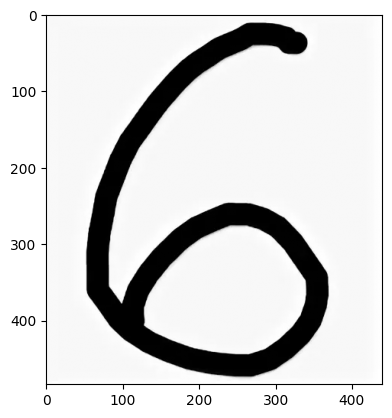

In [384]:
img = cv2.imread(global_path / "6.jpg", 0)
plt.imshow(img, cmap="gray")
img = 255-img
img = cv2.resize(img, (28, 28), interpolation = cv2.INTER_AREA)
blob = cv2.dnn.blobFromImage(img, 1./128, (28,28), (127.5,127.5,127.5), True)

model.setInput(blob)
outs = model.forward()
np.argmax(outs)

In [381]:
def visual_all_numbers(model):
    image = cv2.imread(global_path / "0-9.png")
    plt.imshow(image, cmap="gray")

    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    height, width = img.shape[:2]

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x+w-1, y+h-1), (255,255,0),1)
        sz2 = int(1.1*max(w,h)/2)
        xc = x + int(w/2)
        yc = y + int(h/2)
        cv2.rectangle(image, (xc-sz2, yc-sz2), (xc+sz2, yc+sz2), (255,0,0),1)
        img2 = img[max(0,yc-sz2):min(yc+sz2,height-1),max(0,xc-sz2):min(width-1,xc+sz2)]
        img2 = cv2.resize(img2, (28, 28))
        blob = cv2.dnn.blobFromImage(img2, 1./127, (28,28), (127,127,127), True)
        model.setInput(blob)
        outs = model.forward()
        res = np.argmax(outs)

        cv2.putText(image, str(res), (x-10, y+10),  cv2.FONT_HERSHEY_SIMPLEX,
      1.5, (50, 50, 255),1)

    plt.imshow(image, cmap="gray")

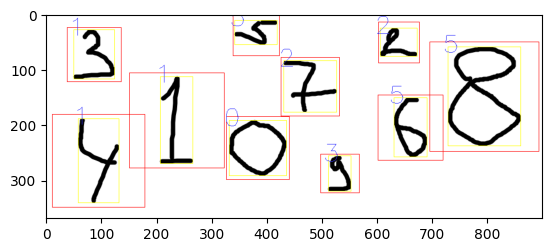

In [387]:
visual_all_numbers(model)